Previous Code: Drone Controller

In [ ]:
group_number = 16

In [ ]:
# This is an example from the Crazyflie Python API.
# See https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/basiclogSync.py

import logging
import time

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)


# Initialize the low-level drivers (don't list the debug drivers)
cflib.crtp.init_drivers(enable_debug_driver=False)
# Scan for Crazyflies and use the first one found
print('Scanning interfaces for Crazyflies...')
available = cflib.crtp.scan_interfaces()
print('Crazyflies found:')
for i in available:
    print(i[0])

if len(available) == 0:
    print('No Crazyflies found, cannot run example')
else:
    lg_stab = LogConfig(name='Stabilizer', period_in_ms=10)
    lg_stab.add_variable('stabilizer.roll', 'float')
    lg_stab.add_variable('stabilizer.pitch', 'float')
    lg_stab.add_variable('stabilizer.yaw', 'float')

    cf = Crazyflie(rw_cache='./cache')
    with SyncCrazyflie(available[0][0], cf=cf) as scf:
        with SyncLogger(scf, lg_stab) as logger:
            endTime = time.time() + 10

            for log_entry in logger:
                timestamp = log_entry[0]
                data = log_entry[1]
                logconf_name = log_entry[2]

                print('[%d][%s]: %s' % (timestamp, logconf_name, data))

                if time.time() > endTime:
                    break

ModuleNotFoundError: No module named 'cflib'

In [ ]:
# @title
# Code adapted from: https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/autonomousSequence.py

import time
# CrazyFlie imports:
import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger

## Some helper control functions:
## -----------------------------------------------------------------------------------------

# Determine initial position:
def wait_for_position_estimator(scf):
    print('Waiting for estimator to find position...')

    log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
    log_config.add_variable('kalman.varPX', 'float')
    log_config.add_variable('kalman.varPY', 'float')
    log_config.add_variable('kalman.varPZ', 'float')

    var_y_history = [1000] * 10
    var_x_history = [1000] * 10
    var_z_history = [1000] * 10

    threshold = 0.001
    with SyncLogger(scf, log_config) as logger:
        for log_entry in logger:
            data = log_entry[1]

            var_x_history.append(data['kalman.varPX'])
            var_x_history.pop(0)
            var_y_history.append(data['kalman.varPY'])
            var_y_history.pop(0)
            var_z_history.append(data['kalman.varPZ'])
            var_z_history.pop(0)

            min_x = min(var_x_history)
            max_x = max(var_x_history)
            min_y = min(var_y_history)
            max_y = max(var_y_history)
            min_z = min(var_z_history)
            max_z = max(var_z_history)

            print("{} {} {}".
                format(max_x - min_x, max_y - min_y, max_z - min_z))

            if (max_x - min_x) < threshold and (
                    max_y - min_y) < threshold and (
                    max_z - min_z) < threshold:
                break

# Initialize controller:
def set_PID_controller(cf):
    # Set the PID Controller:
    print('Initializing PID Controller')
    cf.param.set_value('stabilizer.controller', '1')
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')

    wait_for_position_estimator(cf)
    time.sleep(0.1)
    return

# Ascend and hover:
def ascend_and_hover(cf):
    # Ascend -- warmup drone:
    for y in range(20):
        cf.commander.send_hover_setpoint(0, 0, 0, y / 50)
        time.sleep(0.1)
    # Hover at 0.5 meters:
    for _ in range(30):
        #TODO: write the command to hover at .5 meters
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    return

# Follow the setpoint sequence trajectory:
def run_sequence(scf, sequence, setpoint_delay):
    cf = scf.cf
    # TODO: write the for loop that loops over positions in the sequence
    for position in sequence:
        print(f'Setting position {(position[0], (position[1]))}')
        # "setpoint delay" is a parameter to give the drone time to reach the set point
        for i in range(setpoint_delay):
            cf.commander.send_position_setpoint(position[0],
                                                (position[1]),
                                                0.5,
                                                0.0)
            time.sleep(0.1)

# Hover, descend, and stop all motion:
def hover_and_descend(cf):
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    # Descend:
    for y in range(10):
        cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 25)
        time.sleep(0.1)
    # Stop all motion:
    for i in range(10):
        cf.commander.send_stop_setpoint()
        time.sleep(0.1)
    return

def run_setpoint_trajectory(group_number, sequence):
    # This is the main function to enable the drone to follow the trajectory.

    # User inputs:
    #
    # - group_number: (int) the number corresponding to the drone radio settings.
    #
    # - sequence: a series of point locations (float) defined as a numpy array, with each row in the following format:
    #     [x(meters), y(meters)]
    #   Note: the input should be given in drone coordinates (where positive x is forward, and positive y is to the left).
    # Example:
    # sequence = [
    #     [[ 0.          0.        ]
    #      [0.18134891  0.08433607]]
    #

    # Outputs:
    # None.

    setpoint_delay = 3  # Number of 0.1s steps to spend at each setpoint

    # Set the URI the Crazyflie will connect to
    uri = f"radio://0/{group_number}/2M"

    # Initialize Crazyflie radio drivers
    cflib.crtp.init_drivers(enable_debug_driver=False)

    # Connect to the drone and run the control loop
    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        # Initialize the PID controller and Kalman estimator
        set_PID_controller(cf)

        # TODO: Ascend to safe height before moving
        ascend_and_hover(cf)

        # TODO: Run the sequence of setpoints
        run_sequence(scf, sequence, setpoint_delay)

        # TODO: Descend and stop all motion
        hover_and_descend(cf)

    print("Done!")
    return



In [ ]:
# @title
class Drone_Controller:

  def __init__(self, grid_width, rows, cols, group_number):
      self.grid_width = grid_width
      self.rows = rows
      self.cols = cols
      self.position = np.array([0,0])
      self.group_number = group_number

  def discretize_move(self, action, start_point, segments):

    move_seq = np.zeros((segments+1,2))
    cur = start_point
    move_seq[0] = cur
    increment = self.grid_width / segments

    #TODO -- implement our discretizing strategy on a move!
    # HINT: going "up" means positive in the x-value, "left" is positive in the y-value
    #       Think about the Right hand rule!

    if action == "up":
      for i in range(1, segments + 1):
        move_seq[i,0] = move_seq[i-1,0] + increment
        move_seq[i,1] = move_seq[i-1,1]

    elif action == "down":
      for i in range(1, segments + 1):
        move_seq[i,0] = move_seq[i-1,0] - increment
        move_seq[i,1] = move_seq[i-1,1]

    elif action == "left":
      for i in range(1, segments + 1):
        move_seq[i,0] = move_seq[i-1,0]
        move_seq[i,1] = move_seq[i-1,1] + increment

    elif action == "right":
      for i in range(1, segments + 1):
        move_seq[i,0] = move_seq[i-1,0]
        move_seq[i,1] = move_seq[i-1,1] - increment
    print("adding, ", move_seq)
    return move_seq


  def convert_traj_to_setpoint(self, policy, start, goal, segments, drone_init_pos):
      """
      Converts a list of actions (up/down/left/right) into a sequence of setpoints.

      Parameters:
      - policy: policy recovered by QLearning
      - start: grid position of start in the GridWorld, (x,y)
      - goal: grid position of the end in the GridWorld, (x,y)
      - segments: the amount by which we discretize each move
      - drone_init_pos: the literal start point of the drone, usually (0,0)

      """
      # TODO: make a trajectory and find a list of actions using trajectory.step()
      trajectory = Trajectory(policy)
      actions = trajectory.step(start, goal)

      #initialize setpoints
      setpoints = np.array(drone_init_pos).reshape((1,2))

      # TODO: loop through the actions in our list, and calculate the next set of
      #       setpoints. Add them to our setpoints using np.concatenate((array 1, array 2), axis = 0)
      # HINT: we need to make sure we start each new setpoint from our last known position.
      #       using the index [-1] gets us to the end of a list...
      for a in actions:
        print("calling disc move for action: ", a, ", from setpoint: ", setpoints[-1])
        next_seg = self.discretize_move(a, setpoints[-1],segments)
        setpoints = np.concatenate((setpoints, next_seg), axis = 0)

      return setpoints

  def convert_actions_to_setpoint(self, actions, segments, drone_init_pos):
      setpoints = np.array(drone_init_pos).reshape((1,2))

      # TODO: loop through the actions in our list, and calculate the next set of
      #       setpoints. Add them to our setpoints using np.concatenate((array 1, array 2), axis = 0)
      # HINT: we need to make sure we start each new setpoint from our last known position.
      #       using the index [-1] gets us to the end of a list...

      for a in actions:
        print("calling disc move for action: ", a, ", from setpoint: ", setpoints[-1])
        next_seg = self.discretize_move(a, setpoints[-1],segments)
        setpoints = np.concatenate((setpoints, next_seg), axis = 0)

      return setpoints


  def execute_sequence(self, sequence):
    run_setpoint_trajectory(self.group_number, sequence)
    return

Previous Code for Q-Learning

In [ ]:
# @title
from typing import Tuple
%pip install celluloid
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm, Normalize
import numpy as np
import random


### Visualization Tools ###

### Visualization Tools ###

class Move_anim:
    """
    This class provides functionality for visualizing the motion of a trained
    agent in real-time using matplotlib and a camera-like snapshot tool.

    Args:
        ax_obj (matplotlib axis): The axis to draw the animation on.
        cam_obj (camera object): The camera used to capture frames (e.g., celluloid).
        obs (list or np.ndarray): List of obstacle coordinates.
        goal (list or np.ndarray): Goal coordinate.
        bounds (list): Boundary coordinates.
        grid_size (float): Size of each grid cell in the animation.
        T (float): Time to animate a single move.
        invert (bool): Whether to swap row/col in coordinate conversion.
    """

    def __init__(self, ax_obj, cam_obj, obs, goal, bounds, grid_size=1, T=1, invert=False):
        self.move_time = T
        self.grid_size = grid_size
        self.ax = ax_obj
        self.camera = cam_obj
        self.invert = invert
        self._legend_drawn = False

        # Ensure obs and goal are numpy arrays
        self.obs = np.array(obs) if not isinstance(obs, np.ndarray) else obs
        self.goal = np.array(goal) if not isinstance(goal, np.ndarray) else goal
        self.bounds = bounds


    def right(self, x, y):
        "Animate a rightward move"
        for i in range(int(self.move_time * 10)):
            x += self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def left(self, x, y):
        "Animate a leftward move"
        for i in range(int(self.move_time * 10)):
            x -= self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def up(self, x, y):
        "Animate an upward move"
        for i in range(int(self.move_time * 10)):
            y -= self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def down(self, x, y):
        "Animate a downward move"
        for i in range(int(self.move_time * 10)):
            y += self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def show_obs(self):
        "Show all static objects: obstacles, boundaries, and goal"
        def adapt_coords(pos):
            row, col = pos
            return (col + 0.5, row + 0.5) if self.invert else (row + 0.5, col + 0.5)

        # Draw obstacles (red x)
        for pos in self.obs:
            x, y = adapt_coords(pos)
            self.ax.scatter(x, y, c='red', marker='x', s=100)

        # Draw boundaries (black x)
        for pos in self.bounds:
            x, y = adapt_coords(pos)
            self.ax.scatter(x, y, c='black', marker='x', s=100)

        # Draw goal (green star)
        gx, gy = adapt_coords(self.goal)
        self.ax.scatter(gx, gy, c='green', marker='*', s=200)

        # Draw legend once
        if not self._legend_drawn:
            self.ax.scatter([], [], c='red', marker='x', s=100, label='Obstacle')
            self.ax.scatter([], [], c='black', marker='x', s=100, label='Boundary')
            self.ax.scatter([], [], c='green', marker='*', s=200, label='Goal')
            self.ax.scatter([], [], c='black', edgecolors='white', s=120, marker='o', label='Agent')
            self._legend_drawn = True

    # Execute and animate a full trajectory from (cur_x, cur_y)
    def execute_traj(self, traj, cur_x, cur_y):
        # Optionally swap row and col based on display preference
        if self.invert:
            cur_x, cur_y = cur_y, cur_x

        # Offset to center agent in the middle of a grid cell
        x = cur_x + 0.5
        y = cur_y + 0.5

        # Move the agent step-by-step based on the trajectory list
        for move in traj:
            if move == "right":
                x, y = self.right(x, y)
            elif move == "left":
                x, y = self.left(x, y)
            elif move == "up":
                x, y = self.up(x, y)
            elif move == "down":
                x, y = self.down(x, y)
            else:
                # No move (could handle invalid move here)
                x, y = x, y

        # Show legend after the full trajectory is played
        self.ax.legend(loc='upper right', fontsize=10)



### Method for visualizing q-table with directions corresponding to optimal actions for each state ###

def draw_q_grid(q_table, env, scale=1.5, actions=["stay", "up", "down", "left", "right"], focus_center=None, focus_size=3):
    """
    Visualizes the Q-values of a grid-based environment using directional arrows and color-coded heatmaps.

    Args:
        q_table (dict): A dictionary with keys as (state, action) pairs and values as Q-values.
        env (GridWorld): The grid environment (used for size and boundary info).
        scale (float): Controls the visual scaling of the plot.
        actions (list): List of action names corresponding to Q-values.
        focus_center (tuple): Optional (x, y) center to zoom into a subsection of the grid.
        focus_size (int): Size of the subsection to show if using focus_center.
    """

    # === Determine region to visualize ===
    if focus_center:
        cx, cy = focus_center
        half = focus_size // 2
        row_range = range(max(0, cy - half), min(env.rows, cy + half + 1))
        col_range = range(max(0, cx - half), min(env.cols, cx + half + 1))
    else:
        row_range = range(env.rows)
        col_range = range(env.cols)

    # Arrow offsets for directional visualization
    dx, dy = 0.25, 0.25
    arrow_dict = {"U": (0, -dy), "D": (0, dy), "L": (-dx, 0), "R": (dx, 0)}

    # === Initialize plot ===
    fig, ax = plt.subplots(figsize=(len(col_range) * scale, len(row_range) * scale))
    ax.set_xlim(0, len(col_range))
    ax.set_ylim(0, len(row_range))
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, len(col_range)+1, 1))
    ax.set_yticks(np.arange(0, len(row_range)+1, 1))
    ax.invert_yaxis()
    ax.grid(True)

    # === Normalize Q-values for color mapping ===
    all_q_vals = [v for (_, v) in q_table.items()]
    min_q = min(all_q_vals) if all_q_vals else -1
    max_q = max(all_q_vals) if all_q_vals else 1
    if min_q < 0 and max_q > 0:
        norm = TwoSlopeNorm(vmin=min_q, vcenter=0, vmax=max_q)
    else:
        norm = Normalize(vmin=min_q, vmax=max_q)
    cmap = plt.cm.bwr  # Blue-White-Red colormap

    # === Iterate over grid cells ===
    for i, row in enumerate(row_range):
        for j, col in enumerate(col_range):
            state = (row, col)

            # Get Q-values for each action at this state
            q_stay  = q_table.get((state, "stay"), 0)
            q_up    = q_table.get((state, "up"), 0)
            q_down  = q_table.get((state, "down"), 0)
            q_left  = q_table.get((state, "left"), 0)
            q_right = q_table.get((state, "right"), 0)

            # Cell center coordinates
            x, y = j, i
            cx, cy = x + 0.5, y + 0.5

            # Identify boundaries
            px, py = state
            boundary = px == 0 or px == env.rows - 1 or py == 0 or py == env.cols - 1

            # === Drawing helper functions ===
            def draw_triangle(points, q_val):
                color = 'black' if boundary else cmap(norm(q_val))
                triangle = patches.Polygon(points, closed=True, facecolor=color, edgecolor='black', alpha=0.85)
                ax.add_patch(triangle)

            def draw_square(origin):
                square = patches.Rectangle(origin, width=1, height=1, facecolor='black', edgecolor='black', alpha=1.0)
                ax.add_patch(square)

            def draw_stay_circle(center, q_val, radius=0.1):
                color = 'black' if (0 in state) or (env.cols-1 in state) else cmap(norm(q_val))
                circle = patches.Circle(center, radius, facecolor=color, edgecolor='black', alpha=0.9)
                ax.add_patch(circle)

            # === Render cell ===
            if boundary:
                draw_square((x, y))
            else:
                # Draw directional triangles for each action
                draw_triangle([(x, y), (x+1, y), (cx, cy)], q_up)
                draw_triangle([(x, y+1), (x+1, y+1), (cx, cy)], q_down)
                draw_triangle([(x, y), (x, y+1), (cx, cy)], q_left)
                draw_triangle([(x+1, y), (x+1, y+1), (cx, cy)], q_right)

                # Draw circle for 'stay' action
                draw_stay_circle((cx, cy), q_stay)

                # Determine best action and annotate with direction
                q_vals = [q_stay, q_up, q_down, q_left, q_right]
                best_action = actions[np.argmax(q_vals)]
                direction = best_action[0].upper()
                ax.text(cx, cy, direction, ha='center', va='center', fontsize=10, color='black')

                # Optional: draw directional arrow
                if direction in arrow_dict:
                    dx, dy = arrow_dict[direction]
                    ax.arrow(cx, cy, dx, dy, width=0.006)

    # === Add colorbar ===
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for colorbar to work
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Q-Value")

    # Final formatting
    plt.title("Q-Value Heatmap")
    plt.tight_layout()
    plt.show()



In [ ]:
# @title
class Trajectory:
  """
  This class provides functionality for extracting or rolling
  out optimal trajectory from learned policy.

  Args:
      policy (dict): A dictionary with keys as state tuples and action strings as values.
      action_step (dict): A dictionary with keys as action strings and values as step tuples

  """

  def __init__(self,policy):
    self.policy = policy
    self.action_step = {
        "up":(-1,0),
        "down":(1,0),
        "right":(0,1),
        "left":(0,-1),
        "stay":(0,0)
    }



  def step(self, start_pos, goal_pos):
    "Recieves starting postion and goal position returns optimal action sequence"
    position = start_pos
    actions = []
    while not (position == goal):
      action = self.policy.get(position)
      actions.append(action)
      print(action)
      step = self.action_step.get(action)
      position = tuple(map(sum,zip(position, step)))
    return actions

#Setup MDP problem



### === Environment: GridWorld === ###
class GridWorld:
    """
    A 2D grid environment for reinforcement learning.
    Supports goal states, obstacles, boundaries, and rewards.
    """
    def __init__(self, obs: dict, goal: dict, rows: int, cols: int,
                 bound_cost: float = -1.0, episode_steps: int = 100):
        self.rows = rows
        self.cols = cols
        self.bound_cost = bound_cost
        self.episode_steps = episode_steps

        # Default penalty for moving into free cells
        self.empty_cost = -0.01
        self.obstacle_cost = -0.8
        self.goal_reward = 1.0

        # Initialize grid with step penalty
        self.grid = np.full((rows, cols), self.empty_cost)
        self.map_grid = np.full((rows, cols), 0)

        # Place obstacles
        for (r, c), val in obs.items():
            self.grid[r, c] = self.obstacle_cost
            self.map_grid[r, c] = -1

        # Place goals
        for (r, c), val in goal.items():
            self.grid[r, c] = self.goal_reward
            self.map_grid[r, c] = 1

        # Set outer boundaries
        self._set_boundaries()

        # Cache positions
        self._cache_positions()

    def _set_boundaries(self):
        self.grid[0, :] = self.bound_cost
        self.grid[-1, :] = self.bound_cost
        self.grid[:, 0] = self.bound_cost
        self.grid[:, -1] = self.bound_cost

        self.map_grid[0, :] = -1
        self.map_grid[-1, :] = -1
        self.map_grid[:, 0] = -1
        self.map_grid[:, -1] = -1

    def _cache_positions(self):
        self.goal_positions = list(zip(*np.where(self.grid == self.goal_reward)))
        self.obstacle_positions = list(zip(*np.where(self.grid == self.obstacle_cost)))
        self.bound_positions = list(zip(*np.where(self.grid == self.bound_cost)))

    def get_reward(self, position):
        """Return the reward value at a given (row, col) position."""
        row, col = position
        return self.grid[row, col]

    def reset_random(self, num_obs, goal_pos):
        # Reset grid
        self.grid = np.full((self.rows, self.cols), self.empty_cost)
        self.map_grid = np.full((self.rows, self.cols), 0)

        # Set boundaries
        self._set_boundaries()

        # Place random obstacles
        obs_list = [[random.randint(1, self.rows - 2), random.randint(1, self.cols - 2)]
                    for _ in range(num_obs)]
        for r, c in obs_list:
            self.grid[r, c] = self.obstacle_cost
            self.map_grid[r, c] = -1

        # Place goal
        self.grid[goal_pos[0], goal_pos[1]] = self.goal_reward
        self.map_grid[goal_pos[0], goal_pos[1]] = 1

        # Update goal positions cache
        self.goal_positions = [goal_pos]

        self._cache_positions()

    def is_terminal(self, position):
        """Check if a state is a terminal (goal) state."""
        return (position in self.goal_positions)



### === Agent === ###
class Agent:
    """
    Grid-based agent that can move in 4 directions or stay in place.
    """
    def __init__(self, action_space=["stay", "up", "down", "left", "right"]):
        self.action_space = action_space

    def reset(self, start_pos):
        """Reset agent to a starting position."""
        self.position = start_pos

    def move(self, action, env: GridWorld):
        """
        Move the agent based on the chosen action, considering environment boundaries.
        """
        row, col = self.position
        if action == "up" and row > 0:
            row -= 1
        elif action == "down" and row < env.rows - 1:
            row += 1
        elif action == "left" and col > 0:
            col -= 1
        elif action == "right" and col < env.cols - 1:
            col += 1
        # "stay" does nothing
        self.position = (row, col)
        return self.position



#Deep Q-Networks (DQN) in Gridworld
In this notebook, we extend your understanding of Q-learning by applying it to more complex state representations using neural networks. Tabular Q-learning works well for small, discrete state spaces, but what if your state includes partial observability, local vision, or continuous values?

That's where Deep Q-Networks (DQN) come in.

🧩 What You'll Build --> A neural network that estimates Q-values directly from features like:

- A local grid patch around the agent (to simulate limited perception)

- The normalized positions of the agent and the goal

- A replay buffer to store past experiences and train the agent more stably

- A target network to improve training stability and reduce overestimation

- An epsilon-greedy strategy to balance exploration vs. exploitation

🔍 Key Concepts Covered

- State encoding: Convert your local surroundings and positions into a vector

- Q-function approximation: Replace the Q-table with a fully connected neural network

- Experience replay: Randomly sample past transitions to break correlations

- Target networks: Use a separate network for stable target value estimates


In [ ]:
%pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import numpy as np
import random
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def encode_local_state(agent_pos, goal_pos, grid, obs_range=1):
    rows, cols = grid.shape
    r, c = agent_pos

    r_start = max(0, r - obs_range)
    r_end   = min(rows, r + obs_range + 1)
    c_start = max(0, c - obs_range)
    c_end   = min(cols, c + obs_range + 1)

    local = grid[r_start:r_end, c_start:c_end].copy()

    padded_local = np.full((2*obs_range + 1, 2*obs_range + 1), -1.0, dtype=np.float32)
    p_r_start = obs_range - (r - r_start)
    p_r_end   = p_r_start + (r_end - r_start)
    p_c_start = obs_range - (c - c_start)
    p_c_end   = p_c_start + (c_end - c_start)
    padded_local[p_r_start:p_r_end, p_c_start:p_c_end] = local

    local_flat = padded_local.flatten()

    agent_norm = [r / rows, c / cols]
    goal_r, goal_c = goal_pos
    goal_norm = [goal_r / rows, goal_c / cols]

    state_vector = np.concatenate([local_flat, agent_norm, goal_norm]).astype(np.float32)
    return state_vector





In [ ]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

BATCH_SIZE   = 128
GAMMA        = 0.99
EPS_START    = 0.9
EPS_END      = 0.1
EPS_DECAY    = 7000          # step-based exponential decay denominator
TAU          = 0.005         # soft target update rate
LR           = 3e-4          # AdamW learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations: int, n_actions: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x):
        return self.layers(x)


steps_done = 0

def select_action(state, policy_net, n_actions):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)   # greedy
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


def optimize_model(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return None

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # final states are stored as None
    non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state),
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None], dim=0)

    state_batch  = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # V(s_{t+1})
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # expected Q
    expected_state_action_values = reward_batch + (GAMMA * next_state_values)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    criterion = nn.SmoothL1Loss()  # Huber
    loss = criterion(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()



def run_training(env, agent, obs_range=2, num_episodes=600, memory_capacity=1000):
    """
    Training loop for DQN on GridWorld:
    - Terminal state or hitting env.episode_steps ends an episode.
    - Reward shaping with Manhattan distance bonus.
    - Reward clipping to [-1, 1] for stable Q-learning.
    """
    actions = agent.action_space
    n_actions = len(actions)

    # Observation size
    start_pos = (random.randint(1, env.rows - 2), random.randint(1, env.cols - 2))
    agent.reset(start_pos)
    dummy_state = encode_local_state(agent.position, env.goal_positions[0], env.map_grid, obs_range)
    n_observations = dummy_state.shape[0]

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(memory_capacity)

    episode_returns, episode_losses = [], []

    for i_episode in range(num_episodes):
        # Reset environment
        start_pos = (random.randint(1, env.rows - 2), random.randint(1, env.cols - 2))
        env.reset_random(num_obs=6, goal_pos=env.goal_positions[0])
        agent.reset(start_pos)

        # Build initial state
        s = encode_local_state(agent.position, env.goal_positions[0], env.map_grid, obs_range)
        state = torch.from_numpy(s).float().unsqueeze(0).to(device)

        ep_return, losses = 0.0, []
        prev_dist = abs(agent.position[0] - env.goal_positions[0][0]) + abs(agent.position[1] - env.goal_positions[0][1])

        # Episode loop
        for t in range(env.episode_steps):
            action_tensor = select_action(state, policy_net, n_actions)
            a_idx = action_tensor.item()
            a_str = actions[a_idx]

            # Environment step
            next_pos = agent.move(a_str, env)
            reward_val = env.get_reward(next_pos)
            done = env.is_terminal(next_pos)

            # Reward shaping with Manhattan distance bonus
            new_dist = abs(next_pos[0] - env.goal_positions[0][0]) + abs(next_pos[1] - env.goal_positions[0][1])
            shaping_bonus = 0.25 * (prev_dist - new_dist)  # positive if moving closer
            reward_val += shaping_bonus
            prev_dist = new_dist

            # Reward clipping
            #reward_val = np.clip(reward_val, -1.0, 1.0) not needed since rewards are manageable
            reward = torch.tensor([reward_val], device=device, dtype=torch.float32)

            # Next state
            if not done:
                s_next = encode_local_state(agent.position, env.goal_positions[0], env.map_grid, obs_range)
                next_state = torch.from_numpy(s_next).float().unsqueeze(0).to(device)
            else:
                next_state = None

            # Store transition
            memory.push(state, action_tensor, next_state, reward)
            state = next_state
            ep_return += reward_val

            # Optimize model
            loss_val = optimize_model(policy_net, target_net, memory, optimizer)
            if loss_val is not None:
                losses.append(loss_val)

            # Soft update target network
            with torch.no_grad():
                for target_param, param in zip(target_net.parameters(), policy_net.parameters()):
                    target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

            if done:
                break

        episode_returns.append(ep_return)
        episode_losses.append(np.mean(losses) if losses else 0.0)

        print(
            f"Episode {i_episode} | Return: {ep_return:.2f} | "
            f"Eps(step={steps_done}): {EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY):.3f} | "
            f"AvgLoss: {episode_losses[-1]:.4f}"
        )

    return policy_net.state_dict(), episode_returns, episode_losses



In [ ]:
import matplotlib.pyplot as plt

def plot_training(rewards, losses):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color=color)
    ax1.plot(rewards, color=color, label='Total Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Avg Loss', color=color)
    ax2.plot(losses, color=color, linestyle='--', label='Avg Loss')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("DQN Training Progress: Reward vs. Loss per Episode")
    fig.tight_layout()
    plt.show()

Streaming output truncated to the last 5000 lines.
Episode 5001 | Return: 3.17 | Eps(step=300896): 0.100 | AvgLoss: 0.0001
Episode 5002 | Return: 2.93 | Eps(step=300904): 0.100 | AvgLoss: 0.0001
Episode 5003 | Return: 2.21 | Eps(step=300909): 0.100 | AvgLoss: 0.0001
Episode 5004 | Return: 3.17 | Eps(step=300918): 0.100 | AvgLoss: 0.0001
Episode 5005 | Return: 2.21 | Eps(step=300923): 0.100 | AvgLoss: 0.0001
Episode 5006 | Return: 2.43 | Eps(step=300931): 0.100 | AvgLoss: 0.0001
Episode 5007 | Return: 2.21 | Eps(step=300936): 0.100 | AvgLoss: 0.0001
Episode 5008 | Return: 2.91 | Eps(step=300946): 0.100 | AvgLoss: 0.0001
Episode 5009 | Return: 2.45 | Eps(step=300952): 0.100 | AvgLoss: 0.0001
Episode 5010 | Return: -8.35 | Eps(step=301564): 0.100 | AvgLoss: 0.0001
Episode 5011 | Return: 1.00 | Eps(step=301565): 0.100 | AvgLoss: 0.0000
Episode 5012 | Return: 0.44 | Eps(step=301773): 0.100 | AvgLoss: 0.0001
Episode 5013 | Return: 2.69 | Eps(step=301780): 0.100 | AvgLoss: 0.0001
Episode 5014

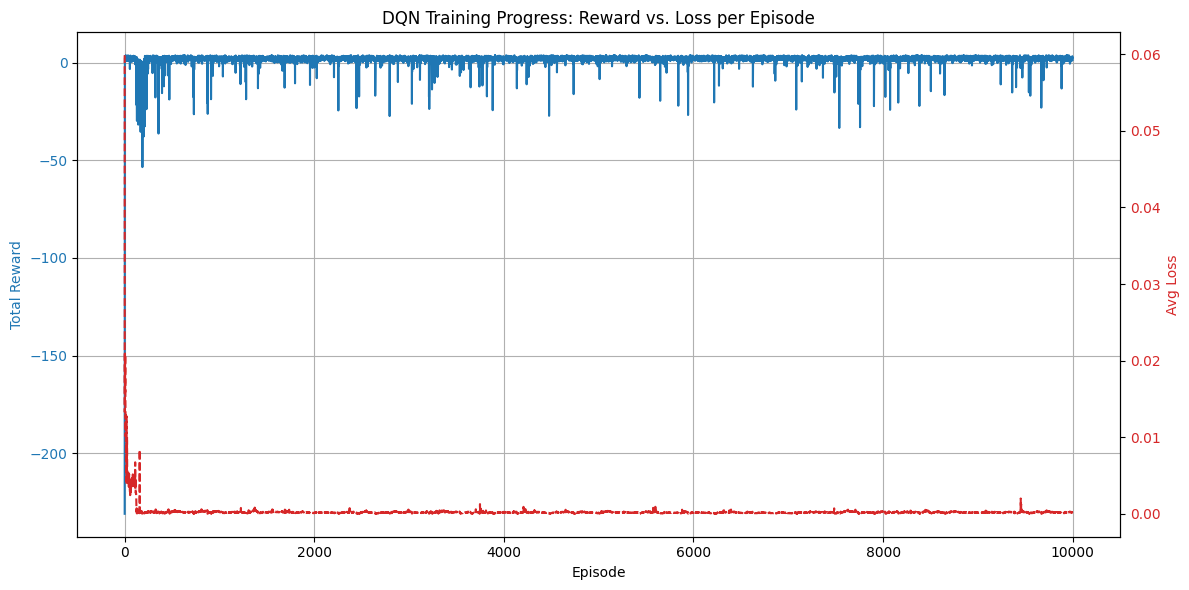

In [ ]:

goal = {
    (1,7): 100
}

obs = {
    (1,1):-50,
    (4,3):-50,
    (2,4):-50
}

env = GridWorld(obs=obs, goal=goal, rows=9, cols=9, episode_steps=1000)

agent = Agent()
trained_dict, rewards, losses = run_training(env, agent, num_episodes=10000)
print(rewards)
plot_training(rewards, losses)


In [ ]:
#Evaluate!

def eval_dqn(state_dict, env, agent, num_eps, obs_range):
    actions = agent.action_space
    input_size = (2*obs_range + 1)**2 + 4
    num_actions = len(actions)

    eval_policy_net = DQN(input_size, num_actions).to(device)
    eval_policy_net.load_state_dict(state_dict)
    eval_policy_net.eval()
    fail_count = 0

    for ep in range(num_eps):
        print("starting episode ", ep)
        env.reset_random(6, env.goal_positions[0])
        agent.reset((random.randint(1, env.rows-2), random.randint(1, env.cols-2)))
        ep_reward = 0.0
        fail = False
        step = 0


        with torch.no_grad():
            while(agent.position not in env.goal_positions):
                state = encode_local_state(agent.position, env.goal_positions[0], env.grid, obs_range)
                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
                q_vals = eval_policy_net(state_tensor)
                action_idx = q_vals.argmax(1).item()

                if(agent.position in env.obstacle_positions or step > 20):
                  fail=True
                  fail_count = fail_count + 1
                  break

                action = actions[action_idx]
                next_pos = agent.move(action, env)
                reward = env.get_reward(next_pos)
                ep_reward += reward
                step += 1


        print("episode complete, reward: ", ep_reward, ", failed to solve: ", fail)
    print("failed to reach goal: ", fail_count)



eval_dqn(trained_dict, env, agent, 1000, 2)


starting episode  0
episode complete, reward:  0.99 , failed to solve:  False
starting episode  1
episode complete, reward:  0.94 , failed to solve:  False
starting episode  2
episode complete, reward:  0.92 , failed to solve:  False
starting episode  3
episode complete, reward:  1.0 , failed to solve:  False
starting episode  4
episode complete, reward:  0.95 , failed to solve:  False
starting episode  5
episode complete, reward:  0.0 , failed to solve:  False
starting episode  6
episode complete, reward:  0.91 , failed to solve:  False
starting episode  7
episode complete, reward:  0.95 , failed to solve:  False
starting episode  8
episode complete, reward:  1.0 , failed to solve:  False
starting episode  9
episode complete, reward:  0.9299999999999999 , failed to solve:  False
starting episode  10
episode complete, reward:  0.9 , failed to solve:  False
starting episode  11
episode complete, reward:  0.94 , failed to solve:  False
starting episode  12
episode complete, reward:  0.98

In [ ]:
#visualize an episode!
from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt


def visualize_episode(state_dict, env, agent, obs_range, start_pos=(2, 8), goal_pos=(1,7)):
    scale = 1
    fig, ax = plt.subplots(figsize=(env.cols * scale, env.rows * scale))
    camera = Camera(fig)

    ax.set_xlim(0, env.cols)
    ax.set_ylim(0, env.rows)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, env.cols + 1, 1))
    ax.set_yticks(np.arange(0, env.rows + 1, 1))
    ax.invert_yaxis()
    ax.grid(True)

    obs = env.obstacle_positions
    bounds = env.bound_positions
    goal = env.goal_positions[0]
    anim = Move_anim(ax, camera, obs, goal, bounds, invert=True)

    actions = agent.action_space
    input_size = (2 * obs_range + 1) ** 2 + 4
    num_actions = len(actions)

    eval_policy_net = DQN(input_size, num_actions).to(device)
    eval_policy_net.load_state_dict(state_dict)
    eval_policy_net.eval()

    env.reset_random(6, goal_pos)
    agent.reset(start_pos)
    ep_reward = 0
    print("Goal", env.goal_positions[0])
    print("Agent Position", agent.position)

    while agent.position != env.goal_positions[0]:
        state = encode_local_state(agent.position, env.goal_positions[0], env.grid, obs_range)
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        with torch.no_grad():
            q_vals = eval_policy_net(state_tensor)
            action_idx = q_vals.argmax(1).item()

        action = actions[action_idx]
        print(action)

        # Animate agent movement
        r, c = agent.position
        if action == "right":
            anim.right(c+.5, r+.5)
        elif action == "left":
            anim.left(c+.5, r+.5)
        elif action == "up":
            anim.up(c+.5, r+.5)
        elif action == "down":
            anim.down(c+.5, r+.5)

        next_pos = agent.move(action, env)
        reward = env.get_reward(next_pos)
        ep_reward += reward

    print("Episode complete, reward:", ep_reward)
    animation = camera.animate()
    plt.close(fig)
    return HTML(animation.to_html5_video())



In [ ]:
#Test your Random Reset!

env = GridWorld(obs=obs, goal=goal, rows=9, cols=9)
env.reset_random(6, (1,7))
print(env.grid)
print(env.map_grid)
print(env.goal_positions[0])

[[-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.4   1.   -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.4  -0.01 -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.4  -0.01 -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.4  -0.01 -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.4  -0.4  -1.  ]
 [-1.   -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -1.  ]
 [-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.  ]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0 -1  1 -1]
 [-1  0  0  0  0  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0 -1  0 -1]
 [-1  0  0  0  0  0 -1  0 -1]
 [-1  0  0  0  0  0 -1 -1 -1]
 [-1  0  0  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]]
(np.int64(1), np.int64(7))


In [ ]:
visualize_episode(trained_dict, env, agent, 2, start_pos=(7, 1))

Goal (np.int64(1), np.int64(7))
Agent Position (7, 1)
up
right
right
right
right
up
up
up
right
up
up
right
Episode complete, reward: 0.89
